In [45]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from scipy.sparse import csr_matrix
import matplotlib as mpl
from scipy.integrate import quad, simpson
import numba
from scipy.integrate import solve_ivp

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward, central
from bachelor_funcs import get_first_dev
from ODE_schemes import A_matrix_regular

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [46]:
N = 2001
x_i = 0.05
x_f = 100
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
ΔT = 1
Δx

0.049975000000000006

In [47]:
# Inital surface density:
def Σ_initial(r, γ = 1):
    return (3 * np.pi * r**γ)**(-1) * np.exp(-r**(2 - γ))

In [48]:
C = 1 / quad(Σ_initial, x_i, x_f)[0]
print(C)

3.8189487957665995


In [49]:
def Σ_initial_norm(r, γ = 1):
    return C * Σ_initial(r, γ)

In [50]:
quad(Σ_initial_norm, x_i, x_f)

(1.0, 1.068841612673277e-09)

#### Self similar solution for $\nu \propto r^γ$

In [51]:
# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

In [52]:
quad(lambda r: Σ(r, 1), x_i, x_f)[0]

1.0

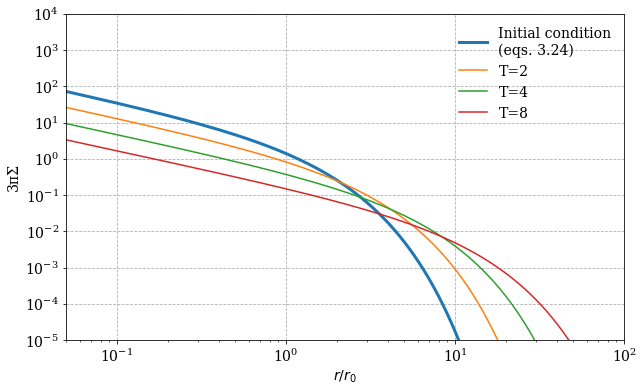

In [53]:
times = [1, 2, 4, 8]
fig, axs = plt.subplots(figsize=(10,6))
plt.grid(ls='--')

axs.loglog(x, (3 * np.pi) * Σ_initial_norm(x), label='Initial condition\n(eqs. 3.24)', lw=3)

for T in times[1:]:
    axs.loglog(x, (3 * np.pi) * Σ(x, T), label=f'T={T}')
plt.legend(frameon = False)

axs.set(xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-1, 2, 4));

### Solving with the physical constants and $\Sigma$ and $r$ initially!

$$\frac{\partial\Sigma}{\partial t}  
= \frac{3}{r} \frac{\partial}{\partial r}
\left[r^{1/2} \frac{\partial}{\partial r}(\nu\Sigma r^{1/2})\right] 
$$
$$\nu \propto r^γ=r^{1}$$

In [54]:
initial_state = Σ_initial_norm(x)

A = A_matrix_regular(N + 2, 3, 1) / Δx
A[0] = 0
A[0, 0] = 1
A[-1] = 0
A[-1, -1] = 1
sA = csr_matrix(A)

In [55]:
ΔT = 1

def disk_evolution(t, Σ):
    #First calculating the inner derivative
    inner = x * Σ * x**(1/2)

    inner_dev = get_first_dev(inner, Δx)
    outer_dev = get_first_dev(x**(1/2) * inner_dev, Δx)

    return 3/x * outer_dev


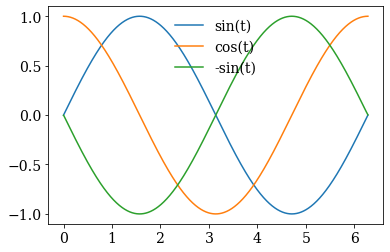

In [56]:
### Test whether "get_first dev" works
t = np.linspace(0, 2 * np.pi, N)

f = np.sin(t, )
f_dev = get_first_dev(f, t[1]-[0])
f_dev2 = get_first_dev(f_dev, t[1]-[0])

plt.plot(t, f, label = 'sin(t)')
plt.plot(t, f_dev, label= 'cos(t)')
plt.plot(t, f_dev2, label= '-sin(t)')

plt.legend(frameon = False)

In [57]:
γ = 1
t_s = (3 * (2 - γ)**2)**(-1)
print(t_s)

t_func = lambda T, ts: (T - 1) * ts
T_func = lambda t, ts: t / ts + 1

0.3333333333333333


### Solving with same boundary conditions as "green_working_boundary"
$$\frac{\partial}{\partial r}(\nu\Sigma r^{1/2})=0$$

In [58]:
def new_bound_ghost(t, Σ):
    inner = x**(1) * Σ * x**(1/2)
    ghost_1 = np.array([inner[1]])
    ghost_2 = np.array([inner[-2]])

    inner_ghost = np.concatenate((ghost_1, inner, ghost_2))
    x_ghost = np.concatenate((np.array([x[0] - Δx]), x, np.array([x[-1] + Δx])))

    outer_ghost = x_ghost**(1/2) * (sA @ inner_ghost) 
    sec_dev = 3 / x_ghost * (sA @ outer_ghost)
    
    return sec_dev[1: -1]

In [59]:
def new_bound_ghost2(t, Σ):
    inner = x**(1) * Σ * x**(1/2)
    inghost_1 = np.array([inner[1]])
    inghost_2 = np.array([inner[-2]])

    inner_ghost = np.concatenate((inghost_1, inner, inghost_2))
    x_ghost = np.concatenate((np.array([x[0] - Δx]), x, np.array([x[-1] + Δx])))

    outer_ghost = x_ghost**(1/2) * (sA @ inner_ghost) 
    outer_ghost[0] = outer_ghost[2]
    outer_ghost[-1] = outer_ghost[-3]
    sec_dev = 3 / x_ghost * (sA @ outer_ghost)
    
    return sec_dev[1: -1]

In [60]:
Tspan = np.array([1, 2, 4, 8])
ΔT = 0.01
#Tspan = np.arange(1, 2 + ΔT, ΔT)
#Tspan = np.arange(1, 8 + 0.01, 0.01)
print(len(Tspan))
tspan = t_func(Tspan, t_s)

sol_bound = solve_ivp(new_bound_ghost, [tspan[0], tspan[-1]], initial_state, t_eval = tspan, method = 'LSODA', atol=1e-4, rtol=1e-6)
sol_bound.t

4


array([0.        , 0.33333333, 1.        , 2.33333333])

Text(0.5, 0.98, 'With boundary')

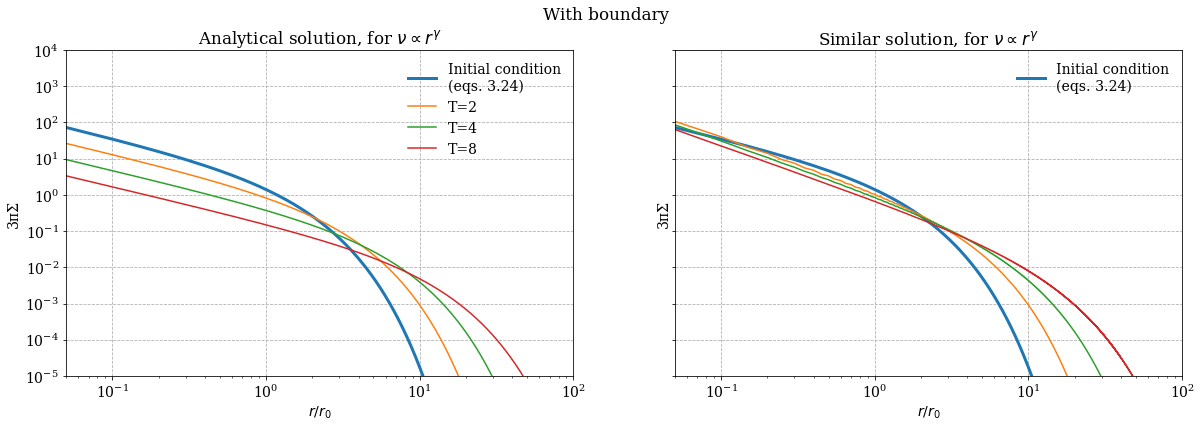

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey=True, sharex=True) 
### Analytical solution ###
axs[0].grid(ls='--')

axs[0].loglog(x, 3 * np.pi * Σ_initial_norm(x), label='Initial condition\n(eqs. 3.24)', lw=3)

for T in times[1:]:
    axs[0].loglog(x, 3 * np.pi * Σ(x, T), label=f'T={T}')
axs[0].legend(frameon = False)

axs[0].set(title='Analytical solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 5));

### Numerical solution ###
axs[1].grid(ls='--')

axs[1].loglog(x, 3 * np.pi * Σ_initial_norm(x), label='Initial condition\n(eqs. 3.24)', lw=3)
for τ in tspan[1:]:
    axs[1].loglog(x, 3 * np.pi * sol_bound.y[:, sol_bound.t == τ])#, label=f'T={T_func(τ, t_s):1.0f}')

axs[1].set(title='Similar solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-1, 2, 4))
axs[1].legend(frameon=False)

fig.suptitle('With boundary')

### Solving with no boundary conditions

In [62]:
sol_nobound = solve_ivp(disk_evolution, [tspan[0], tspan[-1]], initial_state, t_eval = tspan, method = 'LSODA')

Text(0.5, 0.98, 'No boundary')

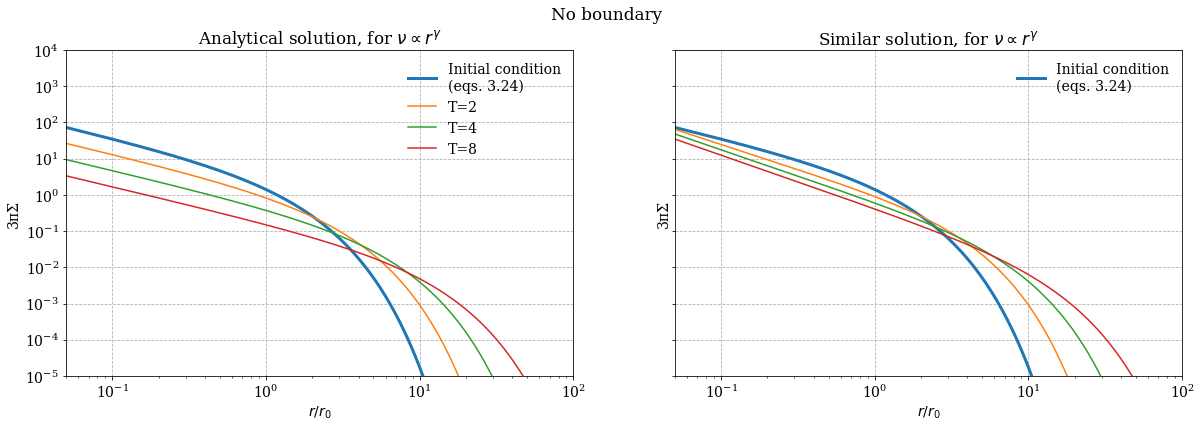

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey=True, sharex=True) 
### Analytical solution ###
axs[0].grid(ls='--')

axs[0].loglog(x, 3 * np.pi * Σ_initial_norm(x), label='Initial condition\n(eqs. 3.24)', lw=3)

for T in times[1:]:
    axs[0].loglog(x, 3 * np.pi * Σ(x, T), label=f'T={T}')
axs[0].legend(frameon = False)

axs[0].set(title='Analytical solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-2, 2, 5));

### Numerical solution ###
axs[1].grid(ls='--')

axs[1].loglog(x, 3 * np.pi * Σ_initial_norm(x), label='Initial condition\n(eqs. 3.24)', lw=3)
for τ in tspan[1:]:
    axs[1].loglog(x, 3 * np.pi * sol_nobound.y[:, sol_nobound.t == τ])#, label=f'T={T_func(τ, t_s):1.0f}')

axs[1].set(title='Similar solution, for $ν \propto r^γ$', xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-1, 2, 4))
axs[1].legend(frameon=False)

fig.suptitle('No boundary')

In [64]:
len(Tspan)

4

In [65]:
print('Integral of analytical solution')
for T in times:
    print(quad(lambda x: Σ(x,T), x_i, x_f)[0])

print('\nIntegral of numerical solution:')
for i, T in enumerate(times):
    print(simpson(sol_nobound.y[:,i], x))


Integral of analytical solution
1.0
0.44933905739799884
0.19334628395866885
0.08065944187677564

Integral of numerical solution:
1.0051924940519854
0.689119131595041
0.4915189088988461
0.3527741920499878


# Residuals: 

[Text(0.5, 0, '$r/r_0$'), Text(0, 0.5, 'res')]

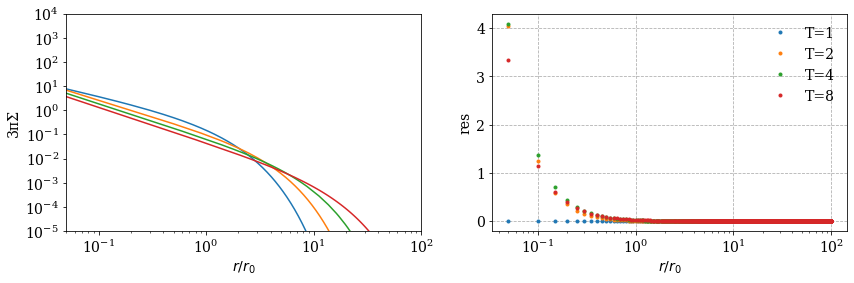

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

for i in range(4):
    axs[0].loglog(x, sol_nobound.y[:,i])

axs[0].set(xlabel='$r/r_0$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (x_i, x_f), yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-1, 2, 4));

for i in range(4):
    axs[1].semilogx(x, sol_nobound.y[:,i] - Σ(x, times[i]), '.', label=f'T={times[i]}')
axs[1].grid(ls='--')
axs[1].legend(frameon = False)
axs[1].set(xlabel='$r/r_0$', ylabel='res')